![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/RECEIPT_BINARY_CLASSIFICATION.ipynb)

# **`RECEIPT_BINARY_CLASSIFICATION`**

## Colab Setup

In [1]:
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==4.1.0

     |████████████████████████████████| 212.4 MB 52 kB/s 
     |████████████████████████████████| 616 kB 21.5 MB/s 
     |████████████████████████████████| 198 kB 69.6 MB/s 


In [2]:
import sparknlp

from pyspark.ml import Pipeline,PipelineModel
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import split, col

from sparknlp.annotator import *
from sparknlp.base import *

import pandas as pd

import warnings
warnings.filterwarnings('ignore')


# Start Spark Session

In [3]:
spark = sparknlp.start()

print("Spark NLP version", sparknlp.version())
print("Apache Spark version:", spark.version)

spark

Spark NLP version 4.1.0
Apache Spark version: 3.1.2


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import shutil

!mkdir model
archive_format = "zip"

model_path = "/content/drive/MyDrive/ticket-ocr/finvisualclf_vit_tickets_en_1.0.0_3.2_1662560058841"

MODEL_NAME =  "model"

# shutil.unpack_archive(filename, extract_dir, archive_format)

shutil.unpack_archive(f'{model_path}.zip', MODEL_NAME, archive_format)

print("Archive file unpacked successfully.")

Archive file unpacked successfully.


# **Identify Receipts in Pictures**

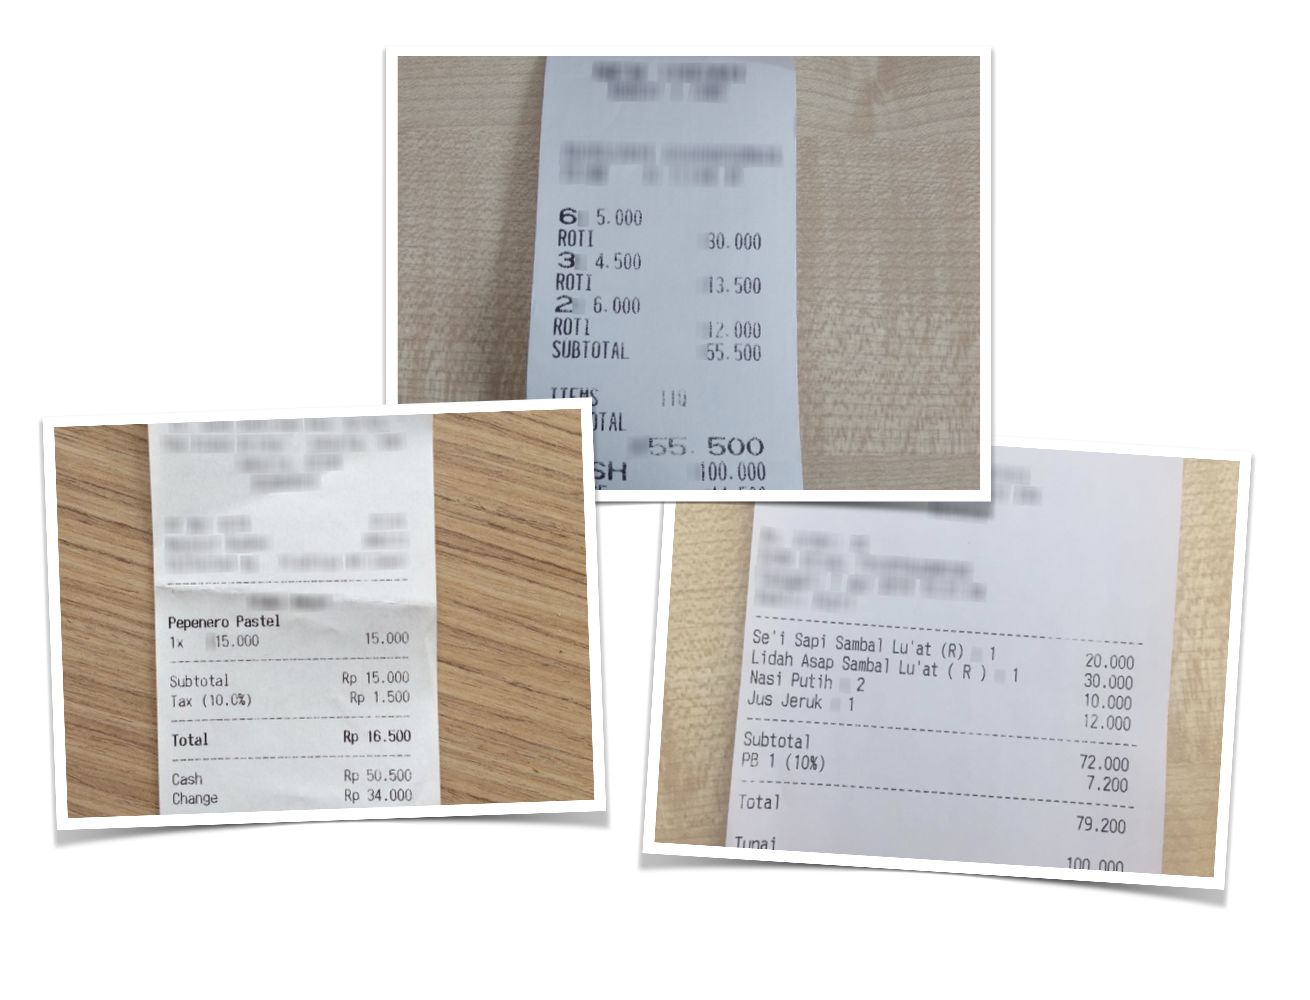

🔎 With this model, you can detect Receipts on both scanned and mobile images using Financial Image Transformers (ViT) in Spark NLP. You can use this model to retrieve all the images which are tickets and then process then using VisualNER, OCR, etc.

🔎 **`finvisualclf_tickets`** is a ViT (Visual Transformer) model, which can be used to carry out Binary Classification (true or false) on pictures / photos / images. This model has been trained in-house with different corpora, including:

* CORD
* COCO
* In-house annotated tickets

🔎 Classes detected by the model:

* **ticket**
* **no_ticket** 

## Load test images

In [6]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/receipt_sample_images/image01.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/receipt_sample_images/image02.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/receipt_sample_images/image03.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/receipt_sample_images/image04.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/receipt_sample_images/image05.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Finance/data/receipt_sample_images/image06.png

In [7]:
test_image = spark.read\
    .format("image")\
    .option("dropInvalid", value = True)\
    .load("*.png").toDF("image")


In [8]:
test_image.select("image.origin", "image.width", "image.height").show(truncate=False)

+---------------------------+-----+------+
|origin                     |width|height|
+---------------------------+-----+------+
|file:///content/image05.png|960  |1280  |
|file:///content/image01.png|1108 |1478  |
|file:///content/image02.png|1920 |2889  |
|file:///content/image06.png|1556 |1760  |
|file:///content/image04.png|1275 |1650  |
|file:///content/image03.png|1108 |1478  |
+---------------------------+-----+------+



# Prediction Pipeline

In [ ]:
document_assembler = ImageAssembler() \
    .setInputCol("image") \
    .setOutputCol("image_assembler")

imageClassifier_loaded = ViTForImageClassification.pretrained("finvisualclf_tickets", "en", "finance/models")\
  .setInputCols(["image_assembler"])\
  .setOutputCol("class")

pipeline = Pipeline().setStages([
                            document_assembler,
                            imageClassifier_loaded])

# Call pipeline

In [12]:
result = pipeline.fit(test_image).transform(test_image).cache()

# Show results

In [13]:
result.show()

+--------------------+--------------------+--------------------+
|               image|     image_assembler|               class|
+--------------------+--------------------+--------------------+
|{file:///content/...|[{image, file:///...|[{category, 0, 5,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 5,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 8,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 8,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 8,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 5,...|
+--------------------+--------------------+--------------------+



In [14]:
result_df = result.select(F.explode(F.arrays_zip("class.result","class.metadata")).alias("cols"))\
                  .select(F.expr("cols['1']['origin']").alias("images"),
                          F.expr("cols['0']").alias("class"),
                          F.expr("cols['1']['Some(ticket)']").alias("ticket_confidence"),
                          F.expr("cols['1']['Some(no_ticket)']").alias("no_ticket_confidence"))
                          

result_df.show(truncate=False)

+---------------------------+---------+-----------------+--------------------+
|images                     |class    |ticket_confidence|no_ticket_confidence|
+---------------------------+---------+-----------------+--------------------+
|file:///content/image05.png|ticket   |0.99478793       |0.0052120956        |
|file:///content/image01.png|ticket   |0.9956969        |0.004303068         |
|file:///content/image02.png|no_ticket|8.144776E-4      |0.9991855           |
|file:///content/image06.png|no_ticket|8.130493E-4      |0.99918693          |
|file:///content/image04.png|no_ticket|8.138706E-4      |0.99918616          |
|file:///content/image03.png|ticket   |0.99545777       |0.0045422423        |
+---------------------------+---------+-----------------+--------------------+



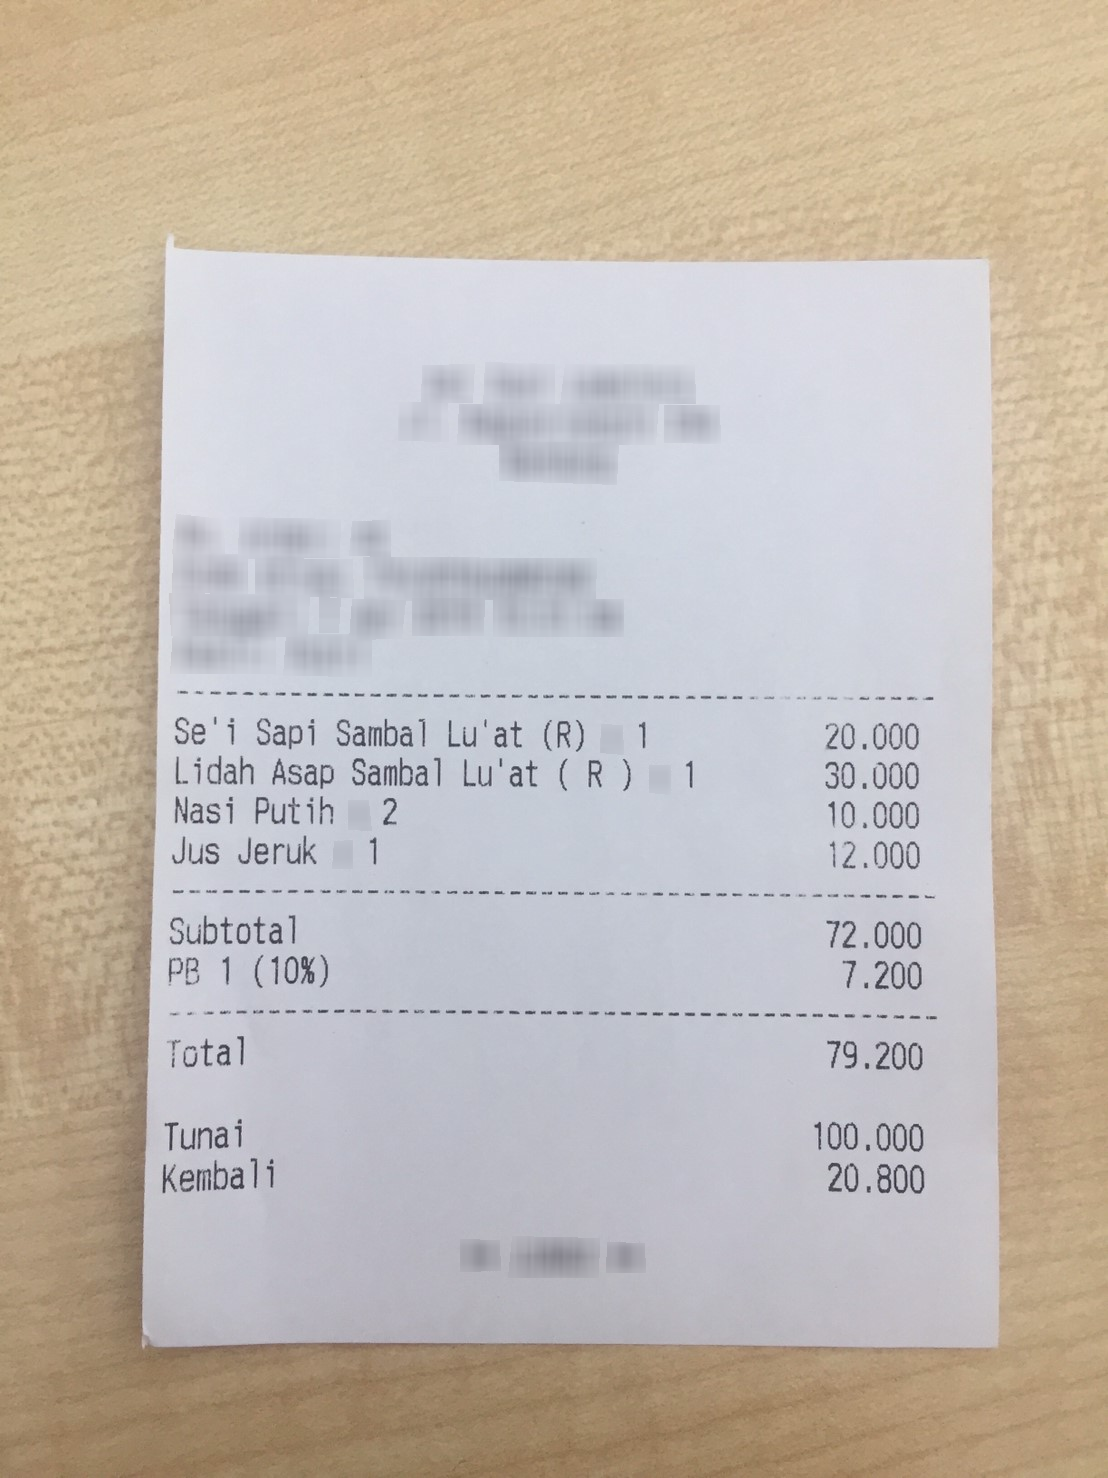

In [15]:
from PIL import Image

image_path = 'image01.png'
pil_im = Image.open(image_path)
display(pil_im)


In [ ]:
result_df.filter(result_df.images == f"file://{image_path}").select("class").show()

+------+
| class|
+------+
|ticket|
+------+



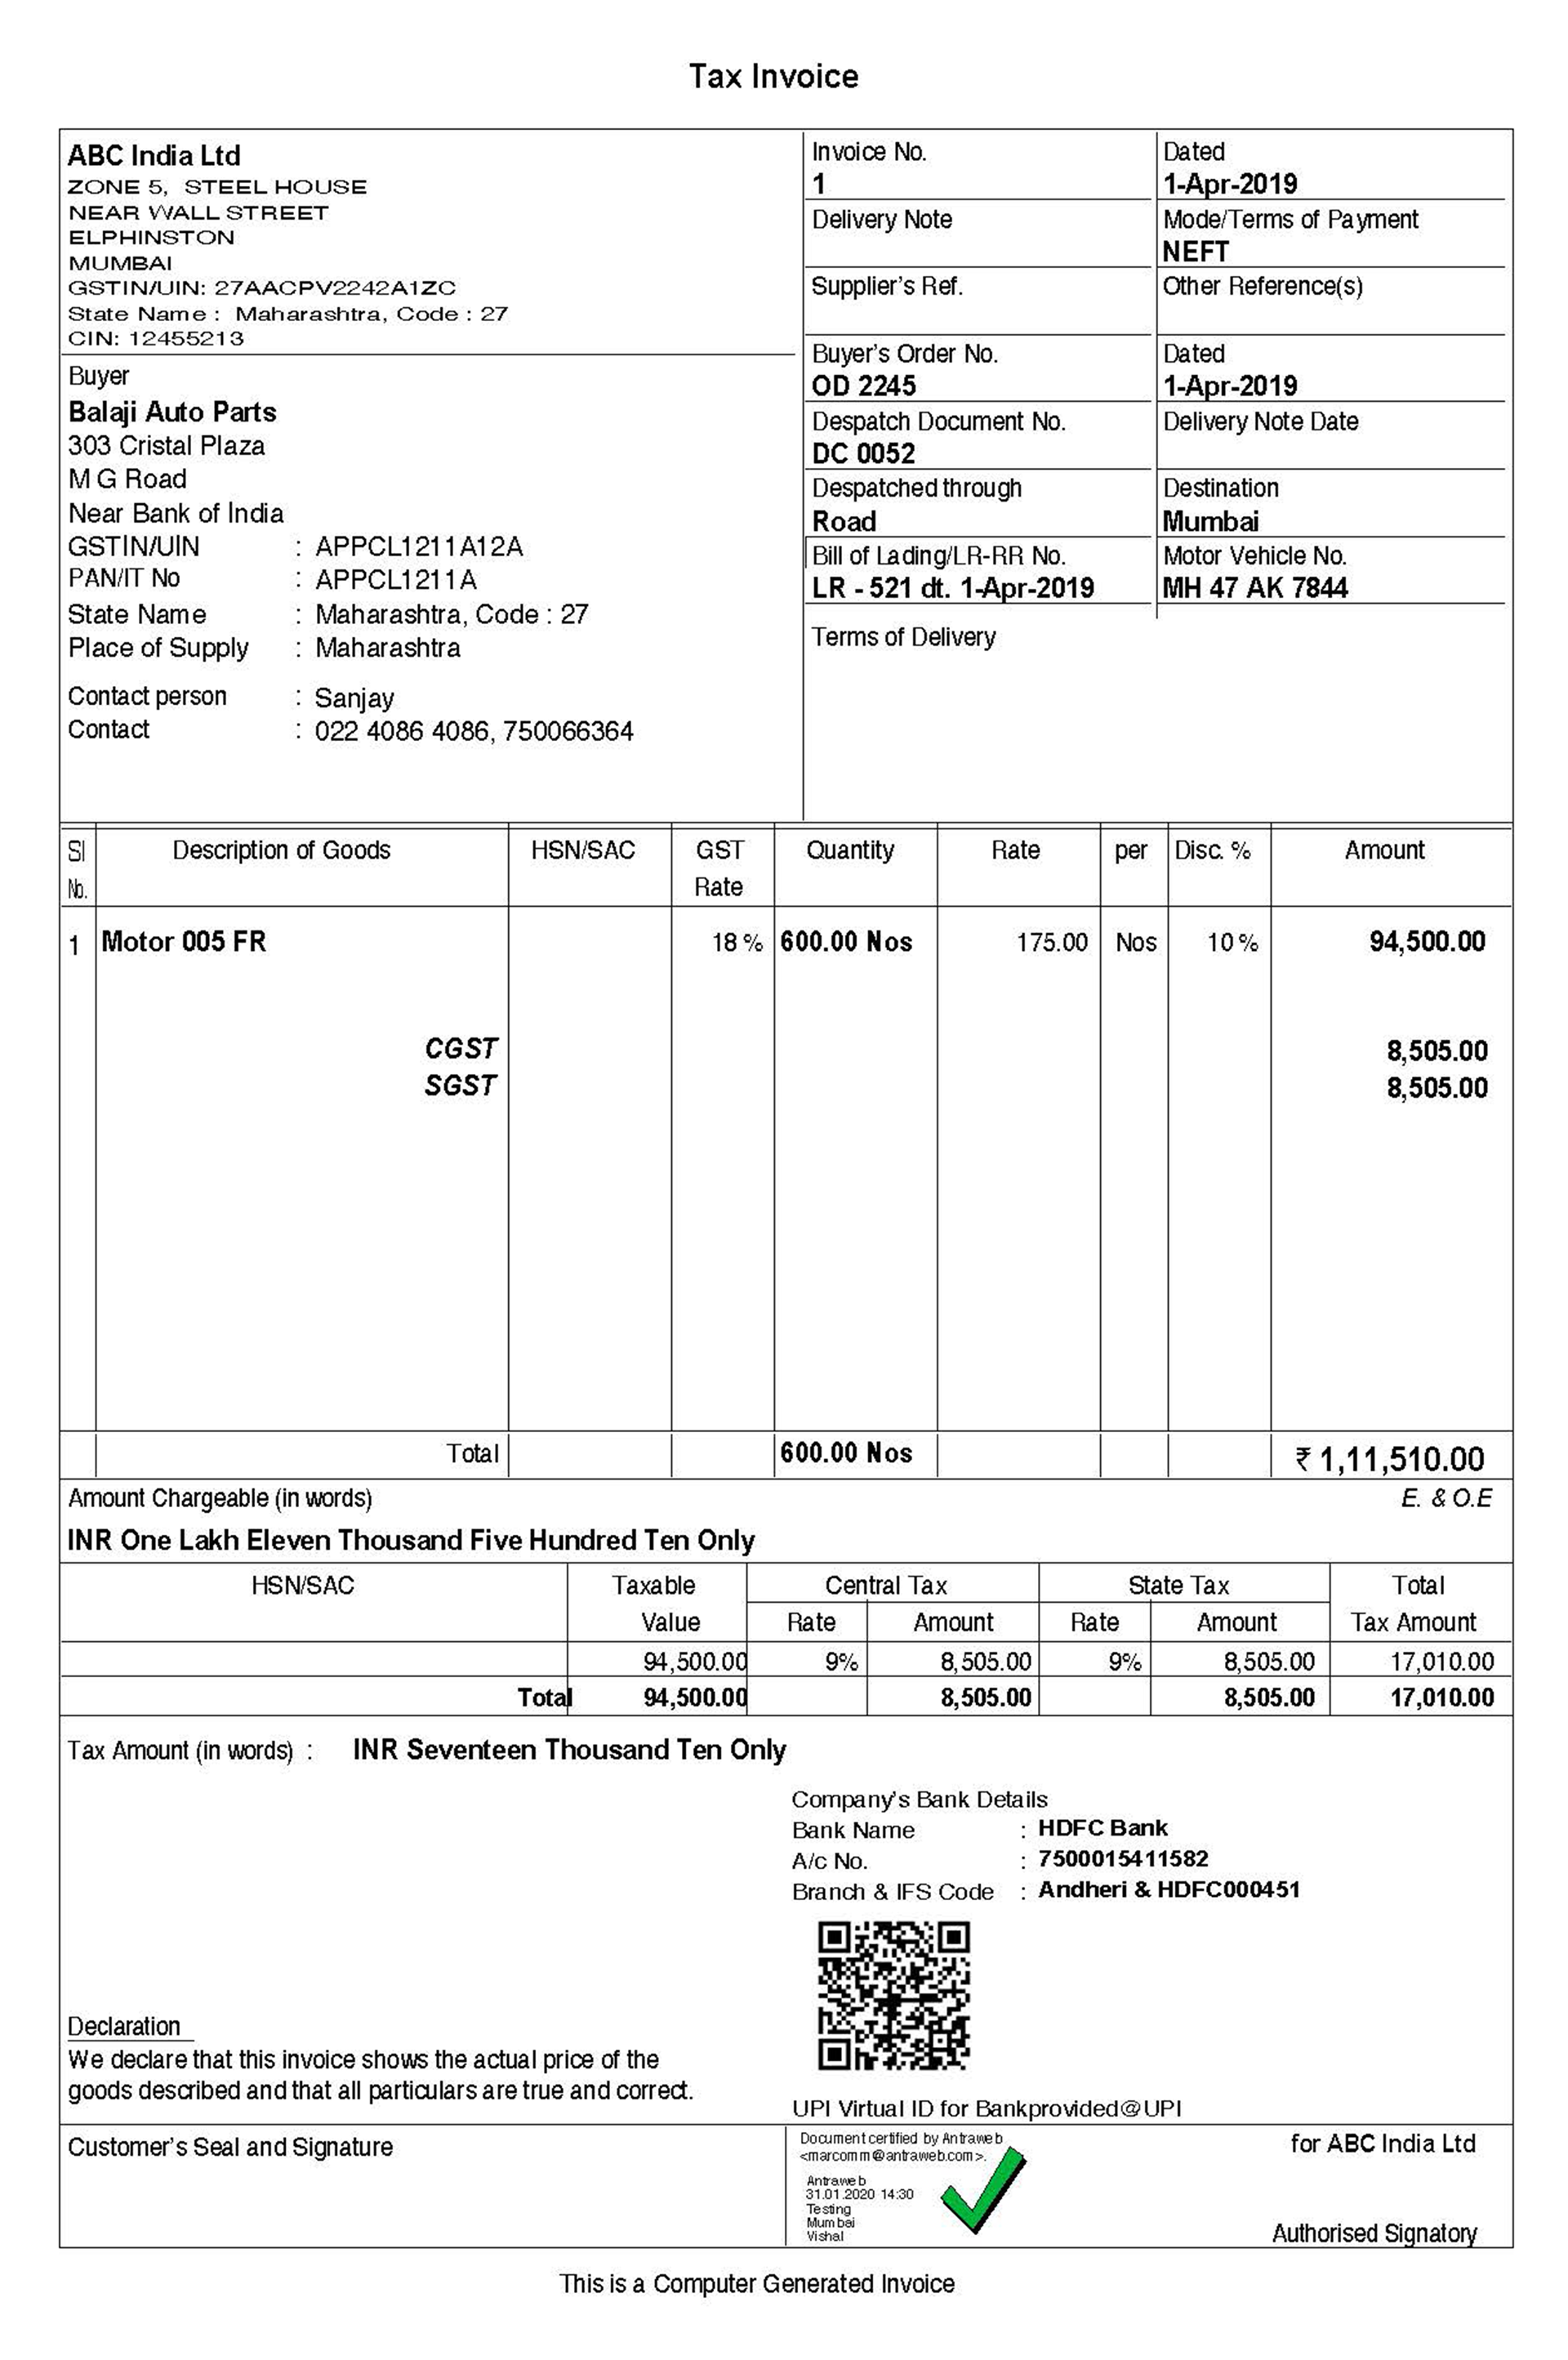

In [16]:
image_path = 'image02.png'
pil_im = Image.open(image_path)
display(pil_im)

In [ ]:
result_df.filter(result_df.images == f"file://{image_path}").select("class").show()

+---------+
|    class|
+---------+
|no_ticket|
+---------+

